In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, r2_score

from lib.utils import get_train_split_data, load_all_resale_data, get_cleaned_normalized_data
from lib.eval import get_regression_metrics

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

In [ ]:
# Load and prepare data
X, y = load_all_resale_data()
X, y = get_cleaned_normalized_data(X, y)
X_train, X_test, y_train, y_test = get_train_split_data(X, y, 0.2)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Loading data from /Users/amonsisowath/VSC/Uni/Sing2425/CS3244/Assignment1/scripts/lib/../data/Resale Flat Prices (Based on Approval Date), 1990 - 1999.csv...
Loading data from /Users/amonsisowath/VSC/Uni/Sing2425/CS3244/Assignment1/scripts/lib/../data/Resale Flat Prices (Based on Approval Date), 2000 - Feb 2012.csv...
Loading data from /Users/amonsisowath/VSC/Uni/Sing2425/CS3244/Assignment1/scripts/lib/../data/Resale Flat Prices (Based on Registration Date), From Mar 2012 to Dec 2014.csv...
Loading data from /Users/amonsisowath/VSC/Uni/Sing2425/CS3244/Assignment1/scripts/lib/../data/Resale Flat Prices (Based on Registration Date), From Jan 2015 to Dec 2016.csv...
Loading data from /Users/amonsisowath/VSC/Uni/Sing2425/CS3244/Assignment1/scripts/lib/../data/Resale flat prices based on registration date from Jan-2017 onwards.csv...
Combined dataset shape: (948962, 11)
Features shape: (948962, 10)
Target shape: (948962,)
Selected features: month, town, flat_type, block, street_name, storey

: 

In [3]:
# Function to plot learning curves
def plot_learning_curve(estimator, X, y, title, ylim=None, cv=5,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score (R²)")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=train_sizes, scoring='r2')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

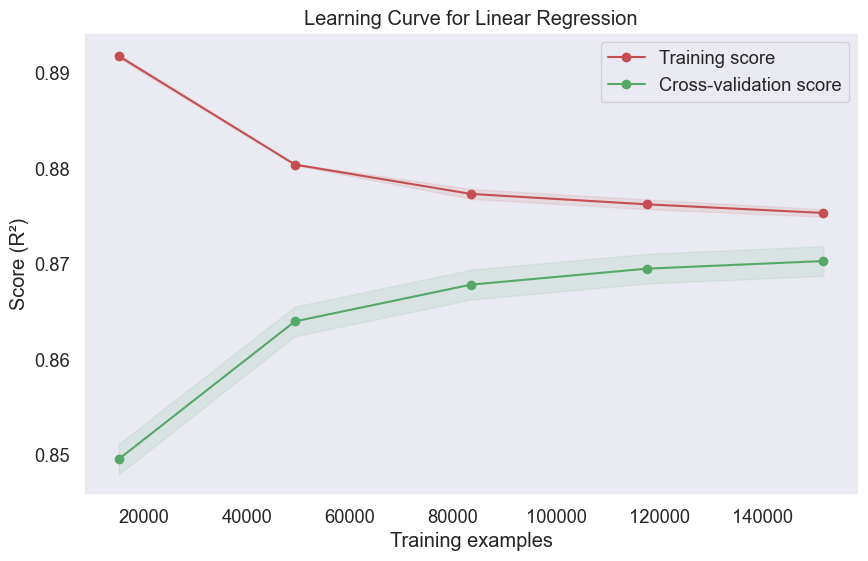

Linear Model - Training RMSE: 62859.50, Test RMSE: 63603.33
Linear Model - Training R²: 0.8749, Test R²: 0.8709


: 

In [ ]:
# 1. Linear model (baseline)
linear_model = LinearRegression()

# Plot learning curve
plot_learning_curve(linear_model, X_train, y_train, 
                   "Learning Curve for Linear Regression")
plt.show()

# Train and evaluate
linear_model.fit(X_train, y_train)
y_pred_train = linear_model.predict(X_train)
y_pred_test = linear_model.predict(X_test)

# Calculate errors
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Linear Model - Training RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Linear Model - Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

In [ ]:
# 2. Test different polynomial degrees to check for underfitting/overfitting
degrees = [1, 2, 3, 5, 7, 10]
train_rmse_list = []
test_rmse_list = []
train_r2_list = []
test_r2_list = []

for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train_poly)
    y_pred_test = model.predict(X_test_poly)
    
    # Calculate errors
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)
    train_r2_list.append(train_r2)
    test_r2_list.append(test_r2)
    
    print(f"Polynomial degree {degree}:")
    print(f"  Training RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    print(f"  Training R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Gap: {train_r2 - test_r2:.4f}")
    print("-" * 50)

Polynomial degree 1:
  Training RMSE: 62859.50, Test RMSE: 63603.33
  Training R²: 0.8749, Test R²: 0.8709
  Gap: 0.0040
--------------------------------------------------


In [ ]:
# Plot the results to visualize overfitting/underfitting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(degrees, train_rmse_list, 'o-', label='Training RMSE')
plt.plot(degrees, test_rmse_list, 'o-', label='Test RMSE')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.title('RMSE vs Polynomial Degree')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(degrees, train_r2_list, 'o-', label='Training R²')
plt.plot(degrees, test_r2_list, 'o-', label='Test R²')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.title('R² vs Polynomial Degree')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# 3. Visualize the "sweet spot" between underfitting and overfitting
plt.figure(figsize=(10, 6))
plt.plot(degrees, np.array(train_r2_list) - np.array(test_r2_list), 'o-', linewidth=2)
plt.axhline(y=0.05, color='r', linestyle='--', alpha=0.7)
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Gap (Training - Test)')
plt.title('Overfitting Indicator: Training vs Test Performance Gap')
plt.grid(True, alpha=0.3)
plt.annotate('Acceptable Region', xy=(1, 0.02), xytext=(2, 0.02), 
             arrowprops=dict(arrowstyle='->'), color='darkgreen')
plt.show()

# Find the optimal degree (smallest gap with good performance)
gaps = np.array(train_r2_list) - np.array(test_r2_list)
performance = np.array(test_r2_list)

# Consider models with gap < 0.1 and sort by test performance
good_models = [(deg, gap, perf) for deg, gap, perf in zip(degrees, gaps, performance) if gap < 0.1]
if good_models:
    good_models.sort(key=lambda x: x[2], reverse=True)
    best_degree = good_models[0][0]
    print(f"Recommended polynomial degree: {best_degree}")
    print(f"This gives test R² of {good_models[0][2]:.4f} with a gap of {good_models[0][1]:.4f}")
else:
    print("All models show significant overfitting. Consider regularization.")

In [ ]:
# 4. Check for potential outliers and their impact on the model
from sklearn.linear_model import Ridge, Lasso

# Train regularized models
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Get predictions from our baseline model again for comparison
y_pred_linear = linear_model.predict(X_test)

# Calculate residuals
residuals_linear = y_test - y_pred_linear
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

# Plot residuals
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_linear, residuals_linear, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Linear Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 3, 2)
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Ridge Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 3, 3)
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Lasso Model Residuals')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()

# Calculate regression metrics for all models
metrics_linear = get_regression_metrics(y_test, y_pred_linear)
metrics_ridge = get_regression_metrics(y_test, y_pred_ridge)
metrics_lasso = get_regression_metrics(y_test, y_pred_lasso)

print("Metrics comparison:")
print(f"Linear - R²: {metrics_linear['r2']:.4f}, RMSE: {metrics_linear['rmse']:.2f}")
print(f"Ridge  - R²: {metrics_ridge['r2']:.4f}, RMSE: {metrics_ridge['rmse']:.2f}")
print(f"Lasso  - R²: {metrics_lasso['r2']:.4f}, RMSE: {metrics_lasso['rmse']:.2f}")

In [ ]:
# 5. Conclusions and recommendations
print("\nConclusions:")
print("=" * 50)

# Compare training and test performance
if train_r2 - test_r2 > 0.1:
    print("- Model shows signs of OVERFITTING (training R² much higher than test R²)")
    print("  Recommendations: Use regularization, reduce model complexity, or gather more data.")
elif test_r2 < 0.5:
    print("- Model shows signs of UNDERFITTING (low R² score on both training and test)")
    print("  Recommendations: Increase model complexity, add more features, or use non-linear models.")
else:
    print("- Model shows good balance between bias and variance.")

# Check if regularization helps
if metrics_ridge['r2'] > metrics_linear['r2'] or metrics_lasso['r2'] > metrics_linear['r2']:
    print("- Regularization improves the model, suggesting potential overfitting in the linear model.")
    
    if metrics_ridge['r2'] > metrics_lasso['r2']:
        print("  Ridge regularization works best, indicating many features contribute partially.")
    else:
        print("  Lasso regularization works best, indicating sparse feature importance.")

# Final recommendations
print("\nFinal Recommendations:")
if good_models:
    print(f"- Use polynomial features with degree {best_degree} for best performance without overfitting.")
    
if metrics_ridge['r2'] > metrics_linear['r2'] and metrics_ridge['r2'] > metrics_lasso['r2']:
    print("- Use Ridge regularization to control model complexity.")
elif metrics_lasso['r2'] > metrics_linear['r2'] and metrics_lasso['r2'] >= metrics_ridge['r2']:
    print("- Use Lasso regularization for feature selection and to control model complexity.")
    
print("- Consider exploring ensemble methods or more sophisticated models if needed.")